# Grid tuning
Several grid modifications to e.g. enhance numerical stability. Starting point for this notebook are the grid files in ../data/preprocessing/interim, which have been generated using the ../src/preprocessing/grid/make_grid.m script.

First, lets generate a copy in ../data/preprocessing/processed/ to work on this copy.

In [2]:
import sys
import os
from shutil import copyfile, move
prep_dir = os.path.join(os.pardir,'data','preprocessing')
grd_old = os.path.join(prep_dir,'interim','waom10_large_MinDepth20m_rx10.3_grd.nc')
grd_new = os.path.join(prep_dir,'processed','waom10_grd.nc')
#copyfile(grd_old,grd_new)

## set water column thickness min to 50m: south of -60S deepen bathy; north of -60S mask
model tends to blow up in shallow ice cavity regions due to to thin vertical layers
deepen bathy together with layer stretching ensures certain vertical level thickness while preserving important GL parts of the cavity

In [16]:
# %load "/home/ubuntu/bigStick/toolBox/myTools/deepen_bathy.py"
import numpy as np
from netCDF4 import Dataset

def deepen_bathy(grid_file,min_depth):
    
    id = Dataset(grid_file,'a')
    h_old = id.variables['h'][:,:]
    zice = id.variables['zice'][:,:]
    lat = id.variables['lat_rho'][:,:]
    mask_old = id.variables['mask_rho'][:,:]
    nbModif = 0
    nbModif_mask = 0
  # calculate watercolumn thickness and mask with land mask
    wc = h_old + zice
    h_new=h_old.copy()
    mask_new = mask_old.copy()
    for iEta in range(np.size(h_old,0)):
        for iXi in range(np.size(h_old,1)):
            if (mask_old[iEta,iXi]==1 and lat[iEta,iXi] <= -60.0 and wc[iEta,iXi]<min_depth):
                h_new[iEta,iXi] = h_old[iEta,iXi] + (min_depth - wc[iEta,iXi])
                nbModif += 1
                
            elif (mask_old[iEta,iXi]==1 and lat[iEta,iXi] > -60.0 and wc[iEta,iXi]<min_depth):
                mask_new[iEta,iXi]==0
                nbModif_mask+=1

    print('     nbModif=', nbModif)
    print('     nbModif_mask=',nbModif_mask)

    id.variables['h'][:,:]= h_new
    id.variables['mask_rho']= mask_new
        
    id.close()

In [26]:
for grd in grd_list:
    print(grd)
    deepen_bathy(grd,50.0)

/home/ubuntu/bigStick/preprocessing/grdgen_mtb/waom10_orig_MinDepth20m_rx10.3_grd.nc_tmp
     nbModif= 3574
     nbModif_mask= 0
/home/ubuntu/bigStick/preprocessing/grdgen_mtb/waom10_small_MinDepth20m_rx10.3_grd.nc_tmp
     nbModif= 3574
     nbModif_mask= 0
/home/ubuntu/bigStick/preprocessing/grdgen_mtb/waom10_medium_MinDepth20m_rx10.3_grd.nc_tmp
     nbModif= 3574
     nbModif_mask= 284
/home/ubuntu/bigStick/preprocessing/grdgen_mtb/waom10_large_MinDepth20m_rx10.3_grd.nc_tmp
     nbModif= 3574
     nbModif_mask= 776


## find rho point that are surrounded by land mask and mask them as well

In [28]:
from find_isolated_points import find_isolated_points
#for grd in grd_list:
#    find_isolated_points(grd)
find_isolated_points(grd_list[0])

number modified =  0


## mask isolated ice shelf points where model tends to blow up
shift the masking boxes in dependence to grid expansion

Box shift in i and j direction: -30, 0
[array([351,  17, 390,  37]), array([ 60, 490,  80, 507]), array([ 37, 432,  37, 432]), array([ 40, 458,  40, 458]), array([565, 257, 569, 262])]


<IPython.core.display.Javascript object>


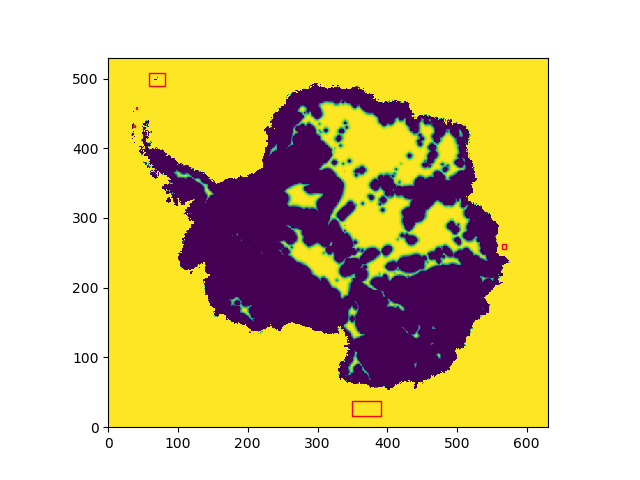

     nbModif= 4
     nbModif= 6
     nbModif= 1
     nbModif= 1
     nbModif= 1


In [32]:
%matplotlib notebook

from matplotlib.patches import Rectangle
from mask_blowup_points import mask_box

id=Dataset(grd_s_tmp,'r')
zice_small=id.variables['zice'][:,:]
id.close()

# boxes for small grid [imin,jmin,imax,jmax]
box1_s=np.array([381,17,420,37])
box2_s=np.array([90,490,110,507])
box3_s=np.array([67,432,67,432])
box4_s=np.array([70,458,70,458])
box5_s=np.array([595,257,599,262])

for grd in [grd_list[0]]:

    box_copy_list = [box1_s.copy(),box2_s.copy(),box3_s.copy(),box4_s.copy(),box5_s.copy()]
    
    id=Dataset(grd,'r')
    mask=id.variables['mask_rho'][:,:]
    zice=id.variables['zice'][:,:]
    id.close()

    #uncomment and comment for all or orig grid size
    #idiff=int((size(zice,1)-size(zice_small,1))/2)
    #jdiff=int((size(zice,0)-size(zice_small,0))/2)
    
    idiff=int((size(zice,1)-size(zice_small,1)))
    jdiff=int((size(zice,0)-size(zice_small,0)))
    
    print("Box shift in i and j direction: "+str(idiff)+', '+str(jdiff))
    for box in box_copy_list:
        box[0]+=idiff
        box[1]+=jdiff
        box[2]+=idiff
        box[3]+=jdiff

    print(box_copy_list)
    
    ind=figure()
    ax1=ind.add_subplot(111,aspect="equal")
    ax1.pcolormesh(zice,vmin=-10)

    # first show the boxes
    for box in box_copy_list:

        ax1.add_patch(Rectangle((box[0]-1, box[1]-1), box[2]-box[0]+2, box[3]-box[1]+2, fill=False,color="r"))

    # then do the masking
    for box in box_copy_list:

        mask_box(grd,box)

## Mask out lonely cells in south america and tassi
### large grid


1. mask box in land areas, which makes things easier later

In [172]:
def mask_box(grid_file,box):

    id = Dataset(grid_file,'a')
    zice = id.variables['zice'][:,:]
    mask_old = id.variables['mask_rho'][:,:]
    mask_new = mask_old.copy()
    nbModif = 0

    [imin,jmin,imax,jmax]=box
    imax=imax+1
    jmax=jmax+1

    for iEta in range(jmin,jmax):
        for iXi in range(imin,imax):
            if (mask_old[iEta,iXi]==1):
                mask_new[iEta,iXi] = 0
                nbModif += 1

    print('     nbModif=', nbModif)


    umask,vmask,pmask=uvp_masks(mask_new)

    id.variables['mask_rho'][:,:]= mask_new
    id.variables['mask_u'][:,:]= umask
    id.variables['mask_v'][:,:]= vmask
    id.variables['mask_psi'][:,:]= pmask

    id.close()


In [173]:
mask_box(grd_list[2],array([39,503,47,511]))

     nbModif= 46


In [174]:
mask_box(grd_list[2],array([858,525,859,529]))

     nbModif= 2


2. define boxes and modify the find_isolated_points algorithm to be used in certain area and with flexibile neigbhour mask points restriction

<IPython.core.display.Javascript object>


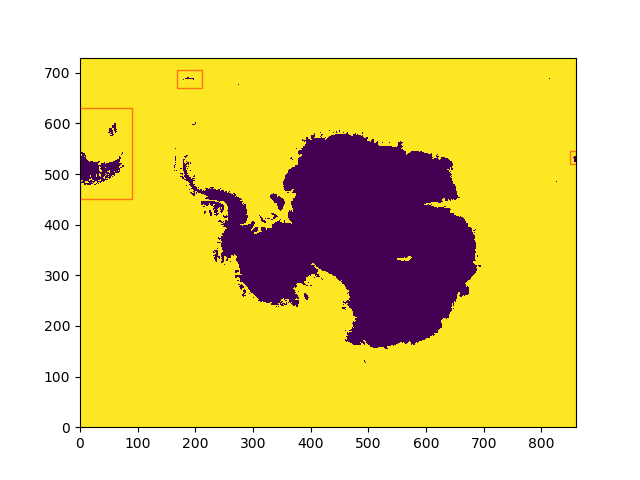

In [176]:
# define boxes and then mask cells with 50% or more mask neighbours
%matplotlib notebook

from matplotlib.patches import Rectangle
from mask_blowup_points import mask_box

id=Dataset(grd_list[2],'r')
mask=id.variables['mask_rho'][:,:]
zice=id.variables['zice'][:,:]
id.close()

# boxes for small grid [imin,jmin,imax,jmax]
box1=array([0,450,90,630])
box2=array([850,520,860,545])
box3=array([168,670,211,705])
box4=array([545,325,583,347]) #vostock for later

box_list=[box1,box2,box3]


fig,ax=subplots()
mask_plt=ax.pcolormesh(mask)
#ice_plt=ax.pcolormesh(zice,vmin=-0.1,alpha=0.3,cmap='bwr')

# first show the boxes
for box in box_list:
    ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], fill=False,color="r",alpha=0.5))


In [42]:
# %load "/home/ubuntu/bigStick/toolBox/myTools/find_isolated_points.py"
from netCDF4 import Dataset
from numpy import *

# Find all of the CICE grid points which are land (or ice shelf) on 3 sides.
# Sea ice can grow in these isolated points but cannot escape due to CICE's
# coastal boundary conditions, so it gets crazy thick (like 2 km thick).
# Print the indices of these points to the screen. This script assumes a
# periodic boundary in the longitude direction.
# Input: cice_kmt_file = path to CICE land mask file, created using cice_grid.py
def find_isolated_points (grd_file,box,nb):

    # Read land mask
    id = Dataset(grd_file, 'a')
    mask_old = id.variables['mask_rho'][:,:]
    mask_new = mask_old.copy()
    nb_modif=0

    # Double loop over box area, can't find a cleaner way to do this
    for j in arange(box[1],box[3]-1):
        for i in arange(box[0],box[2]-1):
            # Check for unmasked points
            if mask_old[j,i] == 1:
                neighbours = array([mask_old[j,i-1], mask_old[j,i+1], mask_old[j-1,i], mask_old[j+1,i]])
                # Blocked on at least 3 sides
                if sum(neighbours) < nb:
                    #print("i=" + str(i+1) + ', j=' + str(j+1))
                    mask_new[j,i]=0
                    nb_modif+=1
    print("number modified = ", nb_modif)

    umask,vmask,pmask=uvp_masks(mask_new)
    
    id.variables['mask_rho'][:,:]= mask_new
    id.variables['mask_u'][:,:]= umask
    id.variables['mask_v'][:,:]= vmask
    id.variables['mask_psi'][:,:]= pmask
    id.close()

    return nb_modif

def uvp_masks(rmask):
    '''
    return u-, v-, and psi-masks based on input rho-mask
    
    Parameters
    ----------
    
    rmask : ndarray
        mask at CGrid rho-points
    
    Returns
    -------
    (umask, vmask, pmask) : ndarrays
        masks at u-, v-, and psi-points
    '''
    rmask = array(rmask)
    assert rmask.ndim == 2, 'rmask must be a 2D array'
    assert all((rmask==0)|(rmask==1)), 'rmask array must contain only ones and zeros.'

    umask = rmask[:, :-1] * rmask[:, 1:]
    vmask = rmask[:-1, :] * rmask[1:, :]
    pmask = rmask[:-1, :-1] * rmask[:-1, 1:] * rmask[1:, :-1] * rmask[1:, 1:]

    return umask, vmask, pmask


*3. In all boxes mask isolated points, which have less then 2 ocean neighbours

In [188]:
for box in box_list:
    nb_modif = inf
    while nb_modif != 0:
        nb_modif = find_isolated_points(grd_list[2],box,2)

number modified =  7
number modified =  1
number modified =  0
number modified =  0
number modified =  0


*4. In south america, mask isolated points, which have less then 3 ocean neighbours

In [187]:
nb_modif = find_isolated_points(grd_list[2],box1,3)

number modified =  105


*5. Plot result and repeat step 4. followed by 5. until satisfied (all lakes on south america masked)

<IPython.core.display.Javascript object>


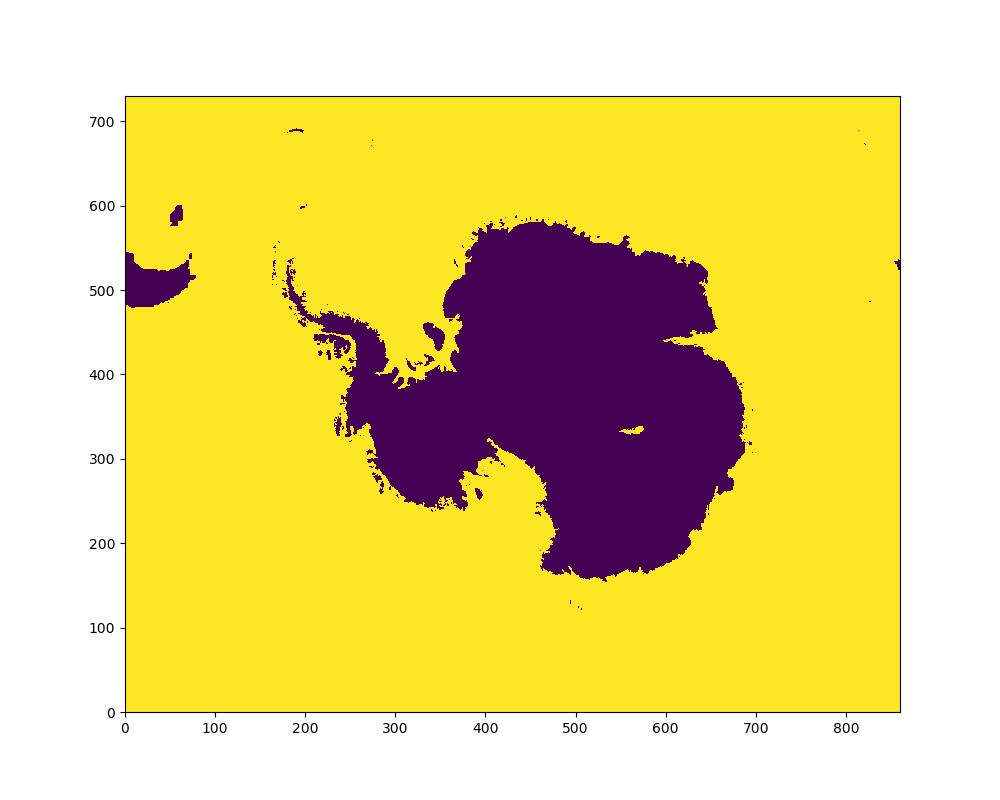

In [189]:
%matplotlib notebook
id=Dataset(grd_list[2],'r')
mask=id.variables['mask_rho'][:,:]
zice=id.variables['zice'][:,:]
id.close()

fig,ax=subplots(figsize=(10,8))
mask_plt=ax.pcolormesh(mask)


## medium grid ... not updated yet

<IPython.core.display.Javascript object>


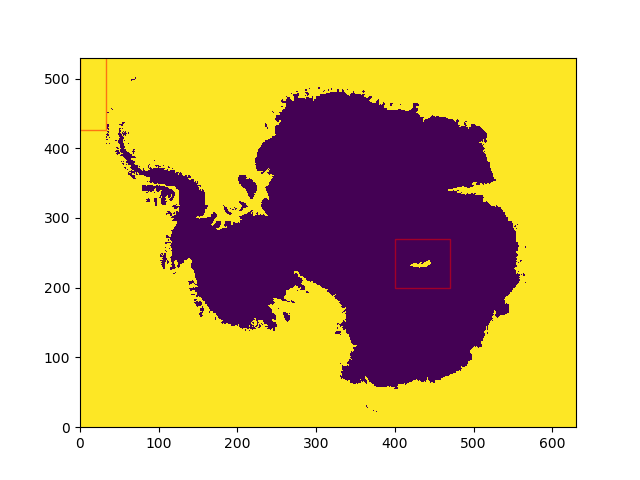

In [40]:
# define boxes and then mask cells with 50% or more mask neighbours
%matplotlib notebook

from matplotlib.patches import Rectangle
from mask_blowup_points import mask_box

id=Dataset(grd_orig_tmp,'r')
mask=id.variables['mask_rho'][:,:]
zice=id.variables['zice'][:,:]
id.close()

# boxes for small grid [imin,jmin,imax,jmax]
box1=array([0,426,33,568])
box2=array([400,200,470,270])

box_list=[box1,box2]


fig,ax=subplots()
mask_plt=ax.pcolormesh(mask)
#ice_plt=ax.pcolormesh(zice,vmin=-0.1,alpha=0.3,cmap='bwr')

# first show the boxes
for box in box_list:
    ax.add_patch(Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], fill=False,color="r",alpha=0.5))


In [43]:
nb_modif = inf
while nb_modif != 0:
    nb_modif = find_isolated_points(grd_orig_tmp,box2,2)

number modified =  5
number modified =  1
number modified =  1
number modified =  0


In [151]:
nb_modif = find_isolated_points(grd_m_tmp,box1,3)

number modified =  62


<IPython.core.display.Javascript object>


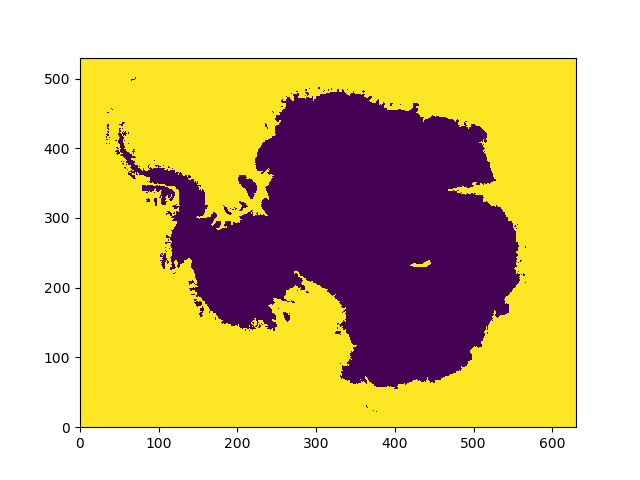

In [44]:
%matplotlib notebook
id=Dataset(grd_orig_tmp,'r')
mask=id.variables['mask_rho'][:,:]
zice=id.variables['zice'][:,:]
id.close()

fig,ax=subplots()
mask_plt=ax.pcolormesh(mask)


## Smooth everything below 2000m or north of -60S and not mask
lift bathy and conserv volume to obey rx0max = 0.2 ... soft smoothing

In [46]:
# first make a copy of the curent status
for grd in [grd_list[0]]:
    grd_tmp=grd+"2"
    copyfile(grd,grd_tmp)
    
grd_orig_tmp ="/home/ubuntu/bigStick/preprocessing/grdgen_mtb/waom10_orig_MinDepth20m_rx10.3_grd.nc_tmp2"
grd_s_tmp ="/home/ubuntu/bigStick/preprocessing/grdgen_mtb/waom10_small_MinDepth20m_rx10.3_grd.nc_tmp2"
grd_m_tmp ="/home/ubuntu/bigStick/preprocessing/grdgen_mtb/waom10_medium_MinDepth20m_rx10.3_grd.nc_tmp2"
grd_l_tmp ="/home/ubuntu/bigStick/preprocessing/grdgen_mtb/waom10_large_MinDepth20m_rx10.3_grd.nc_tmp2"
grd_list=[grd_orig_tmp,grd_s_tmp,grd_m_tmp,grd_l_tmp]
print(grd_list)

['/home/ubuntu/bigStick/preprocessing/grdgen_mtb/waom10_orig_MinDepth20m_rx10.3_grd.nc_tmp2', '/home/ubuntu/bigStick/preprocessing/grdgen_mtb/waom10_small_MinDepth20m_rx10.3_grd.nc_tmp2', '/home/ubuntu/bigStick/preprocessing/grdgen_mtb/waom10_medium_MinDepth20m_rx10.3_grd.nc_tmp2', '/home/ubuntu/bigStick/preprocessing/grdgen_mtb/waom10_large_MinDepth20m_rx10.3_grd.nc_tmp2']


In [48]:
ocean_his_hourly_0006.nc# smooth everything below 2000m and or north of -60.0 S by lifting topo up (make h smaller) and conserve volume
# possibly repeat until nmodif=0
%matplotlib notebook
import smooth_bathy
from importlib import reload
reload(smooth_bathy)
from cartesian_grid_2d import cartesian_grid_2d

ploting = True

for grd in [grd_list[0]]:
    print(grd)
    id=Dataset(grd,'r')
    zice = id.variables['zice'][:,:]
    h=id.variables["h"][:,:]
    mask_rho = id.variables['mask_rho'][:,:]
    lon_u = id.variables['lon_u'][:,:]
    lon_v = id.variables['lon_v'][:,:]
    lat_u = id.variables['lat_u'][:,:]
    lat_v = id.variables['lat_v'][:,:]
    lat_rho = id.variables["lat_rho"][:,:]
    id.close()
    
    mask_deep = np.where(h>=2000.0,1,0)
    mask_north = np.where(lat_rho>=-60.0,1,mask_deep)
    mask = np.where(mask_rho==0,0,mask_north)
    
    zice_new = np.where(lat_rho)
   # fig = figure(figsize=(12,8))
   # pcolormesh(mask)
   # colorbar()
   
    dx,dy=cartesian_grid_2d(lon_u,lat_u,lon_v,lat_v)
    area=dx*dy
    
    h_tmp = h.copy()
    
  
    h_tmp, HmodifVal, ValueFct=smooth_bathy.smoothing_PlusMinus_rx0(mask,h_tmp,0.2,area)
    print(HmodifVal, ValueFct)

/home/ubuntu/bigStick/preprocessing/grdgen_mtb/waom10_orig_MinDepth20m_rx10.3_grd.nc_tmp2
     nbModif= 307
     nbModif= 38
     nbModif= 36
     nbModif= 36
     nbModif= 36
     nbModif= 36
     nbModif= 36
     nbModif= 36
     nbModif= 36
     nbModif= 36
     nbModif= 36
     nbModif= 36
     nbModif= 34
     nbModif= 31
     nbModif= 12
     nbModif= 0
DeltaBathymetry =  16.0
0.000389359301981 70232.3290447


In [49]:
# some coastal points might be shallower than 50 m now. mask them out
wc=h_tmp+zice
print(any(wc<49))
mask_shallow=np.where(wc<49.999,0,mask_rho)
h_masked = ma.masked_where(mask_shallow==0,h_tmp)
wc_masked=ma.masked_where(mask_shallow==0,h_masked-zice)
print(any(wc_masked<50.0))

True
False


In [50]:
print(amin(wc))
print(amin(wc_masked))

0.0999999999999
50.0


<IPython.core.display.Javascript object>


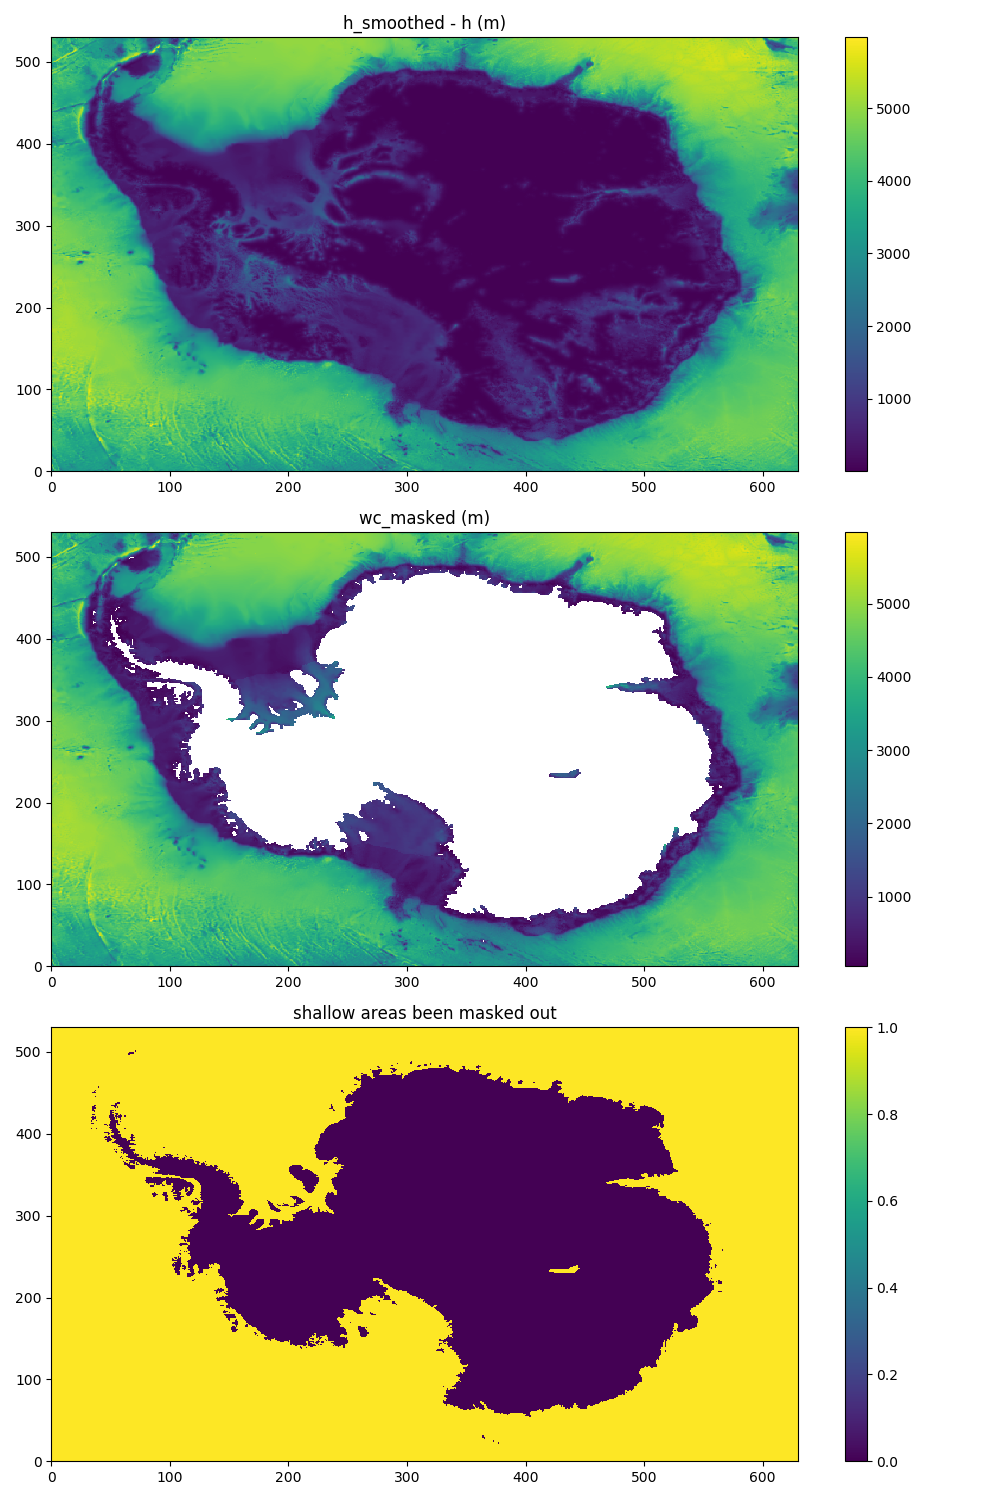

In [61]:
#some checkup plots

fig3 ,(ax1,ax2,ax3)=subplots(3,figsize=(10,15))
im=ax1.pcolormesh(zice_new)
colorbar(im,ax=ax1)
ax1.set_title("h_smoothed - h (m)")

im2=ax2.pcolormesh(wc_masked)
colorbar(im2,ax=ax2)
ax2.set_title("wc_masked (m)")
#ax2.contour(mask)

im3=ax3.pcolormesh(mask_shallow)
colorbar(im3,ax=ax3)
ax3.set_title("shallow areas been masked out")
fig3.tight_layout()

<IPython.core.display.Javascript object>


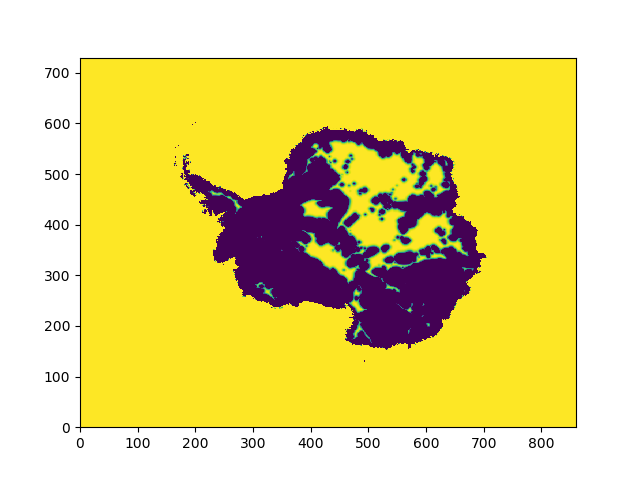

In [245]:
#mask zice above 65S
%matplotlib notebook
mask_58 = np.where(lat_rho>=-59,0.0,1.0)
zice_new=zice*mask_58
pcolormesh(zice_new,vmin=-10)

# fill in the fucking mask in the bathymetry and co!!! ROMS cant handle NaN's
... you simply do this by writing h_tmp.data instead of the masked array.

In [62]:
umask,vmask,pmask=uvp_masks(mask_shallow)

In [64]:
#update bathy and masks in netcdf file
id = Dataset(grd_list[0],'a')
id.variables['h'][:,:]=h_tmp
id.variables['mask_rho'][:,:]=mask_shallow
#id.variables["zice"][:,:]=zice_new
id.variables['mask_u'][:,:]= umask
id.variables['mask_v'][:,:]= vmask
id.variables['mask_psi'][:,:]= pmask
id.close()

## add sponge layer

In [65]:
from add_sponge import add_sponge
viscFac=100
diffFac=50

for grd in [grd_list[0]]:
    add_sponge(grd,viscFac,diffFac)

Reading grid.
Setting up visc and diff Factor arrays.
Writing arrays out to grid file.


## copy straight to raijin to test grid performance
... you might have to generate an ini file first using make_ini_*.py in the preprocessing folder

In [66]:
#copy straight to raijin to test grid
from shutil import move,copy
raijin_path="/home/ubuntu/raijin/short/m68/oxr581/ROMSIceShelf_devel/Data/waom10/waom10_grd.nc"
#move(grd_list[2],raijin_path)
print(grd_list[0],raijin_path)
copyfile(grd_list[0],raijin_path)

/home/ubuntu/bigStick/preprocessing/grdgen_mtb/waom10_orig_MinDepth20m_rx10.3_grd.nc_tmp2 /home/ubuntu/raijin/short/m68/oxr581/ROMSIceShelf_devel/Data/waom10/waom10_grd.nc


'/home/ubuntu/raijin/short/m68/oxr581/ROMSIceShelf_devel/Data/waom10/waom10_grd.nc'

## Optional: Increase DT by buldozer far north regions with hard smoothing approach
... smooth north of -60.0S by lifting bathy, conserve volume until you obey rx0max = 0.1
check for wc <50 and mask and apply mask to uvpsi and fill in mask_rho points when you write out h!

In [67]:
from netCDF4 import Dataset
from numpy import *
from matplotlib.pyplot import *

id=Dataset(grd_list[0],'r')
h=id.variables["h"][:,:]
zice=id.variables['zice'][:,:]
mask_rho = id.variables['mask_rho'][:,:]
lon_u = id.variables['lon_u'][:,:]
lon_v = id.variables['lon_v'][:,:]
lat_u = id.variables['lat_u'][:,:]
lat_v = id.variables['lat_v'][:,:]
lat_rho = id.variables['lat_rho'][:,:]
lon_rho = id.variables['lon_rho'][:,:]
id.close()
#mask_deep = np.where(h>=2000.0,1,0)
mask_north = np.where(lat_rho>=-60.0,1,0)
mask = np.where(mask_rho==0,0,mask_north)

#fig = figure(figsize=(12,8))
#pcolormesh(mask)
#colorbar()
#contour(lat_rho,arange(-60,-50))
#colorbar()

dx,dy=cartesian_grid_2d(lon_u,lat_u,lon_v,lat_v)
area=dx*dy

h_tmp = h.copy()

print("smoothing")

h_tmp, HmodifVal, ValueFct=smooth_bathy.smoothing_PlusMinus_rx0(mask,h_tmp,0.15,area)
print(HmodifVal, ValueFct)        


smoothing
     nbModif= 251
     nbModif= 111
     nbModif= 109
     nbModif= 105
     nbModif= 105
     nbModif= 105
     nbModif= 105
     nbModif= 105
     nbModif= 105
     nbModif= 103
     nbModif= 103
     nbModif= 103
     nbModif= 101
     nbModif= 85
     nbModif= 56
     nbModif= 35
     nbModif= 35
     nbModif= 35
     nbModif= 35
     nbModif= 35
     nbModif= 35
     nbModif= 35
     nbModif= 35
     nbModif= 35
     nbModif= 35
     nbModif= 34
     nbModif= 30
     nbModif= 20
     nbModif= 8
     nbModif= 8
     nbModif= 8
     nbModif= 8
     nbModif= 8
     nbModif= 8
     nbModif= 8
     nbModif= 8
     nbModif= 8
     nbModif= 8
     nbModif= 8
     nbModif= 8
     nbModif= 7
     nbModif= 6
     nbModif= 4
     nbModif= 2
     nbModif= 1
     nbModif= 0
DeltaBathymetry =  0.0
0.000374426483588 65548.4065999


In [68]:
# some coastal points might be shallower than 50 m now. mask them out
wc=(h_tmp+zice)
print(any(wc<49))
mask_shallow=np.where(wc<49.999,0,mask_rho)
print(any(mask_shallow==mask_rho))
#h_masked = ma.masked_where(mask_shallow==0,h_tmp)
wc_masked=ma.masked_where(mask_rho==0,wc)
print(any(wc_masked<49))

True
True
False


In [69]:
print(amin(wc))
print(amin(wc_masked))

0.0999999999999
50.0


<IPython.core.display.Javascript object>


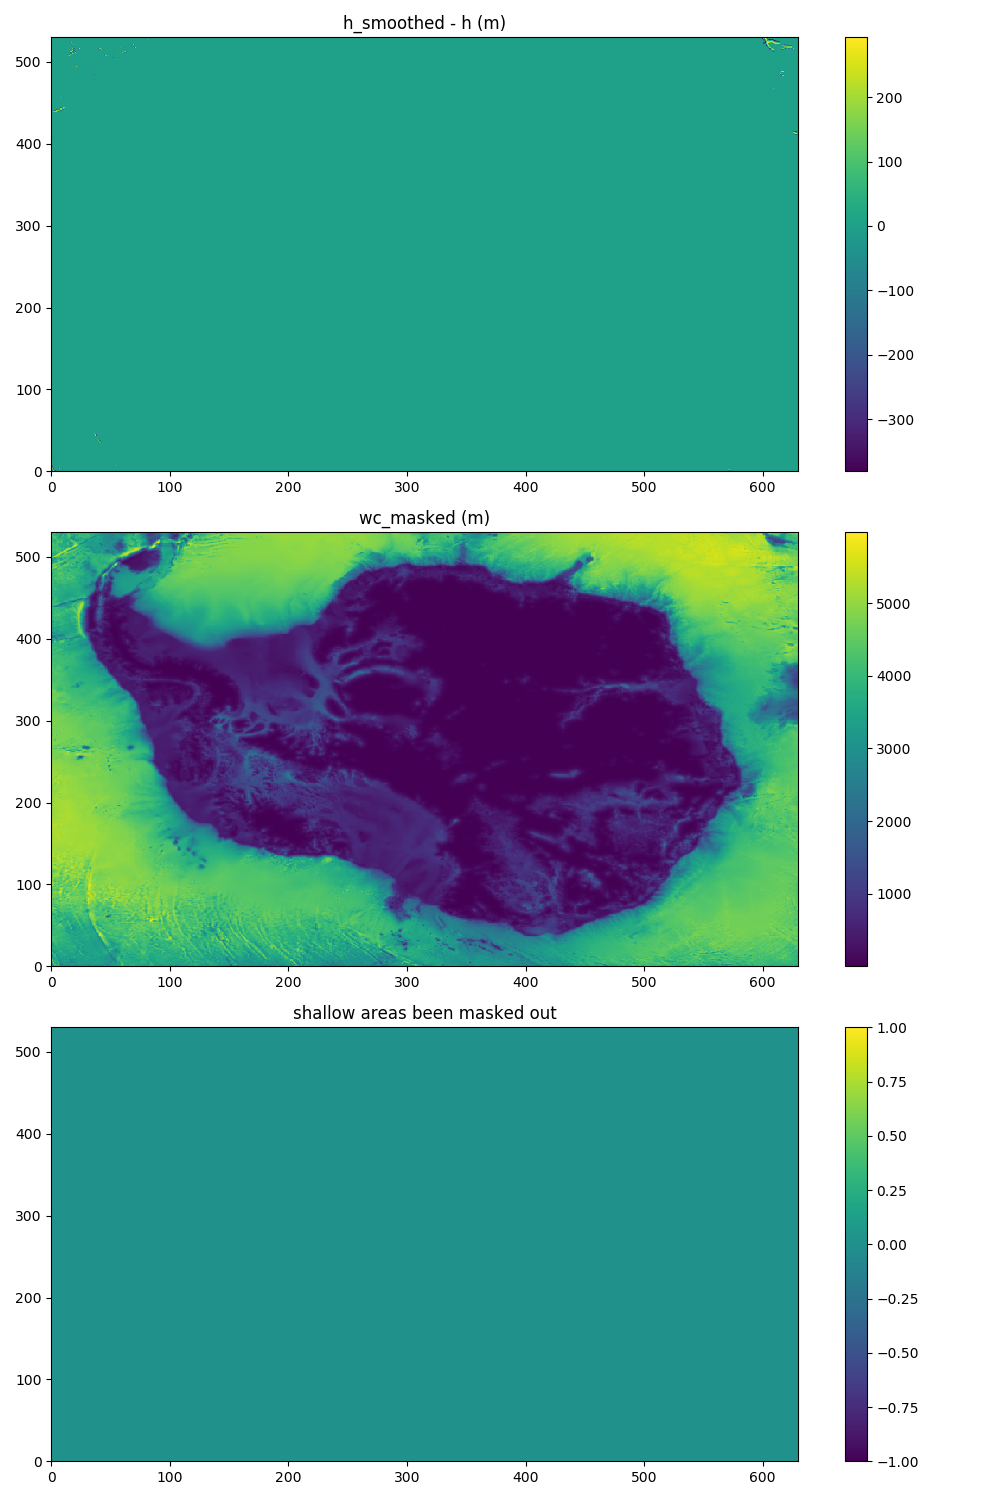

In [73]:
#some checkup plots

fig3 ,(ax1,ax2,ax3)=subplots(3,figsize=(10,15))
im=ax1.pcolormesh((h_tmp-h)*mask_rho)
colorbar(im,ax=ax1)
ax1.set_title("h_smoothed - h (m)")

im2=ax2.pcolormesh(h_tmp)
colorbar(im2,ax=ax2)
ax2.set_title("wc_masked (m)")
#ax2.contour(mask)

im3=ax3.pcolormesh(mask_shallow-mask_rho,vmin=-1,vmax=1)
colorbar(im3,ax=ax3)
ax3.set_title("shallow areas been masked out")
fig3.tight_layout()

# fill in the fucking mask in the bathymetry and co!!! ROMS cant handle NaN's
... you simply do this by writing h_tmp.data instead of the masked array.

In [72]:
umask,vmask,pmask=uvp_masks(mask_shallow)

In [75]:
#update bathy and masks in netcdf file
id = Dataset(grd_list[0],'a')
id.variables['h'][:,:]=h_tmp
id.variables['mask_rho'][:,:]=mask_shallow
#id.variables["zice"][:,:]=zice_new
id.variables['mask_u'][:,:]= umask
id.variables['mask_v'][:,:]= vmask
id.variables['mask_psi'][:,:]= pmask
id.close()

In [76]:
#copy straight to raijin to test grid
from shutil import move,copyfile
raijin_path="/home/ubuntu/raijin/short/m68/oxr581/ROMSIceShelf_devel/Data/waom10/waom10_grd.nc"
#move(grd_list[2],raijin_path)
print(grd_list[0],raijin_path)
copyfile(grd_list[0],raijin_path)

/home/ubuntu/bigStick/preprocessing/grdgen_mtb/waom10_orig_MinDepth20m_rx10.3_grd.nc_tmp2 /home/ubuntu/raijin/short/m68/oxr581/ROMSIceShelf_devel/Data/waom10/waom10_grd.nc


'/home/ubuntu/raijin/short/m68/oxr581/ROMSIceShelf_devel/Data/waom10/waom10_grd.nc'

# add angle to the grid file

read


<IPython.core.display.Javascript object>


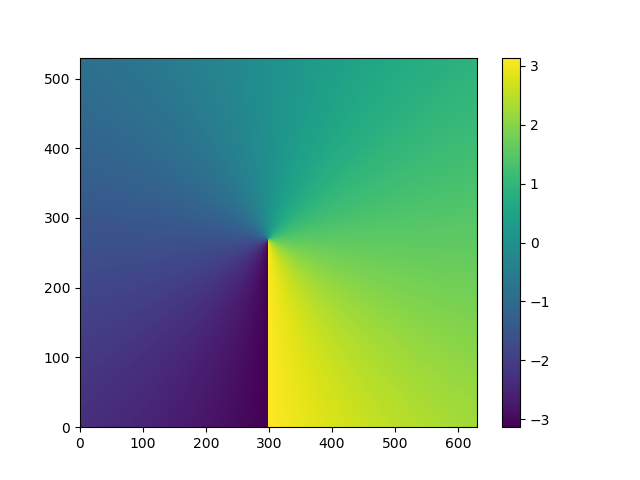

In [1]:
from netCDF4 import Dataset
from numpy import *
from matplotlib.pyplot import *
grd= '/home/ubuntu/raijin/short/m68/oxr581/ROMSIceShelf_devel/Data/waom10/waom10_grd.nc'
print('read')
id = Dataset(grd,'r')
lon=id.variables['lon_rho'][:,:]
id.close()
DTOR = pi/180.0
angle = lon*DTOR
%matplotlib notebook
pcolormesh(angle)
colorbar()


In [2]:
print("write")
id=Dataset(grd,'a')
id.variables['angle'][:,:]=angle[:,:]
#id.variables['angle'].long_name="angle ROMS xi axis is rotated anticlockwise from due east"
#id.variables['angle'].units="radians"
#id.variables['angle'].equation="u(roms)=Real((Ueast+i*Vnorth)*exp(-i*angle)) and v(roms)=Imag((Ueast+i*Vnorth)*exp(-i*angle))"
id.close()

write


In [ ]:
%matplotlib notebook
id=Dataset(raijin_path,'r')
zice = id.variables['zice'][:,:]
h=id.variables["h"][:,:]
mask_rho = id.variables['mask_rho'][:,:]
lon_u = id.variables['lon_u'][:,:]
lon_v = id.variables['lon_v'][:,:]
lat_u = id.variables['lat_u'][:,:]
lat_v = id.variables['lat_v'][:,:]
lat_rho = id.variables['lat_rho'][:,:]
lon_rho = id.variables['lon_rho'][:,:]
id.close()
print("plotting")
#some checkup plots
wc = h + zice
wc_ma = ma.masked_where(mask_rho==0,wc)
zice_ma = ma.masked_where(mask_rho==0,zice)
h_ma = ma.masked_where(mask_rho ==0,h)
print(any(wc<49))

fig3 ,ax1=subplots(1,figsize=(12,8))
im=ax1.pcolormesh(h_ma)
#ax1.contour(mask)
colorbar(im,ax=ax1)
ax1.set_title("h_smoothed - h (m)")
#im2=ax2.pcolormesh(zice,vmin=-10)
#colorbar(im2,ax=ax2)
#ax2.set_title("smoothed bathy (m)")
#ax2.contour(mask)
#im3=ax3.pcolormesh(wc,vmax=50,vmin=0)

#colorbar(im3,ax=ax3)
#ax3.set_title("smoothed wc (m)")
#fig3.tight_layout()


False


<IPython.core.display.Javascript object>


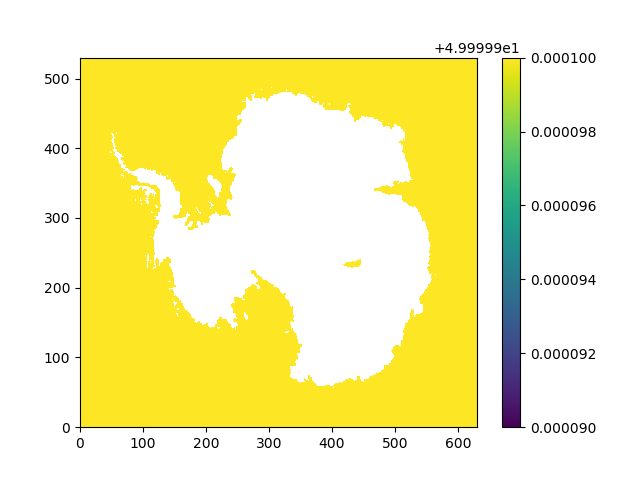

In [135]:
%matplotlib notebook
id=Dataset("/home/ubuntu/raijin/short/m68/oxr581/waom10_avg/Data/waom10/waom10_grd.nc",'r')
zice = id.variables['zice'][:,:]
h=id.variables["h"][:,:]
mask_rho = id.variables['mask_rho'][:,:]
lon_u = id.variables['lon_u'][:,:]
lon_v = id.variables['lon_v'][:,:]
lat_u = id.variables['lat_u'][:,:]
lat_v = id.variables['lat_v'][:,:]
lat_rho = id.variables['lat_rho'][:,:]
lon_rho = id.variables['lon_rho'][:,:]
id.close()
wc=h+zice
wc = ma.masked_where(mask_rho==0,wc)
print(any(wc<49.9))
pcolormesh(wc,vmin=49.99999,vmax=50.0)
colorbar()

## update grid_file, perhaps generate a new ini file and test again

In [103]:
#update bathy in netcdf file
id = Dataset(grd_list[2],'a')
id.variables['h'][:,:]=h_tmp
id.close()
#copy straight to raijin to test grid
from shutil import move,copy
raijin_path="/home/ubuntu/raijin/short/m68/oxr581/waom10_domain_study/Data/waom10/waom10_grd_large.nc"
#move(grd_list[2],raijin_path)
copy(grd_list[2],raijin_path)

'/home/ubuntu/raijin/short/m68/oxr581/waom10_domain_study/Data/waom10/waom10_grd_large.nc'

## move final versions of grid files into bigStick/waom10Grids/

In [64]:
# move final versions to bigStick/waom10Grids/
from shutil import move
grd_s_final ="/home/ubuntu/bigStick/waom10Grids/waom10_grd_small.nc"
grd_m_final ="/home/ubuntu/bigStick/waom10Grids/waom10_grd_medium.nc"
grd_l_final ="/home/ubuntu/bigStick/waom10Grids/waom10_grd_large.nc"

grd_list_final=[grd_s_final,grd_m_final,grd_l_final]
for i in arange(len(grd_list)):
    move(grd_list[i],grd_list_final[i])

FileNotFoundError: [Errno 2] No such file or directory: '/home/ubuntu/bigStick/preprocessing/grdgen_mtb/waom10_small_MinDepth20m_rx10.3_grd.nc_tmp'